In [1]:
# Importing the required libraries.
import numpy as np
import pandas as pd
import pickle, zlib
from random import sample
import scipy.cluster.hierarchy as sch
from gensim.models.doc2vec import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import single, fcluster
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import single, cophenet
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestCentroid
from collections import Counter
import sys
import math
sys.setrecursionlimit(5000)

In [2]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [4]:
#Downsampling
def sampling(data):
    limit = 10000
    ind = []
    if len(data)>limit:
        ind = sample([i for i in range(len(data))],limit)
        data = [data[i] for i in ind]
    else:
        ind = [i for i in range(len(data))]
    return data,ind

In [5]:
#choose method and metric
def choose_metric(data):
    method = ['single','complete','average','weighted','centroid','ward']
    metric = ['euclidean','cosine']
    maxx = None
    use_method = None
    use_metric = None
    '''for m1 in method:
        for m2 in metric:
            try:
                linkage_matrix = sch.linkage(data, m1, metric=m2)
                c, coph_dists = cophenet(linkage_matrix, pdist(data))
                print("Method=",m1," Metric=",m2," Cophenet coeff=",c)
                plot_dendro(linkage_matrix)
                if maxx is None or c>maxx:
                    maxx = c
                    use_method = m1
                    use_metric = m2
                print(m1,m2,c)
            except Exception as e:
                print(e)'''
    use_method ='ward' #input('Input the suitable method: ')
    use_metric = 'euclidean' #input('Input the suitable metric: ')
    return use_method,use_metric

In [6]:
#Plot dendrograms and we are interested in huge jump in distance 
def plot_dendro(linkage_matrix):
    for threshold in np.arange(10,110,10):
        labels = sch.fcluster(linkage_matrix, threshold, criterion='distance')
        fancy_dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            p=30,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            annotate_above=10,  # useful in small plots so annotations don't overlap
            max_d=threshold
            )
        plt.show()
        break

In [7]:
#Eliminate outlier clusters
def eliminate_outlier(data,linkage_matrix,method,metric,thresh=50):
    labels = sch.fcluster(linkage_matrix, thresh, criterion='distance')
    d = Counter(labels)
    sorted_d = sorted(d.items(), key = lambda kv:(kv[1], kv[0])) 
    maxx = None
    art_thresh = None
    '''val = 1
    ind = 0
    flag = False
    while maxx is None or flag:
        flag = False
        val = sorted_d[ind][1]
        clusters = [i for i,j in sorted_d if j==val]
        ind = sorted_d.index((clusters[-1],val))+1
        indices = []
        for c in clusters:
            indices = indices+[i for i, x in enumerate(labels) if x == c]
        revised_data = [data[i] for i in range(len(data)) if i not in indices]
        linkage_matrix = sch.linkage(revised_data, method, metric=metric)
        c, coph_dists = cophenet(linkage_matrix, pdist(revised_data))
        print(val,c)
        if maxx is None or c>maxx:
            maxx = c
            flag = True
    return val
    '''
    itm = list(d.values())
    for art in range(1,101):
        if art not in itm:
            continue
        clusters = []
        for i,j in sorted_d:
            if j<art:
                clusters.append(i)
        indices = []
        for c in clusters:
            indices = indices+[i for i, x in enumerate(labels) if x == c]
        revised_data = [data[i] for i in range(len(data)) if i not in indices]
        #print(len(revised_data),len(indices),len(data1))
        linkage_matrix = sch.linkage(revised_data, method, metric=metric)
        c, coph_dists = cophenet(linkage_matrix, pdist(revised_data))
        
        if maxx is None or c>=maxx:
            maxx = c
            art_thresh = art
    print(art_thresh,c,maxx)
    return art_thresh
        

In [8]:
#Compute rank
def compute_scr(linkage_matrix,data,art_thresh,thresh=50):
    labels = sch.fcluster(linkage_matrix, thresh, criterion='distance')
    d = Counter(labels)
    sorted_d = sorted(d.items(), key = lambda kv:(kv[1], kv[0])) 
    clusters = []
    for i,j in sorted_d:
        if j<=art_thresh:
            clusters.append(i)
    indices = []
    for c in clusters:
        indices = indices+[i for i, x in enumerate(labels) if x == c]
    ind = [i for i in range(len(data)) if i not in indices]
    revised_data = [data[i] for i in ind]
    labels=list(labels)
    labels = [labels[i] for i in ind]
    #print(len(ind),len(revised_data),len(data))
    clf = NearestCentroid()
    clf.fit(revised_data, labels) 
    centroids = clf.centroids_
    num1 = [i for i in range(len(set(labels)))]
    num2 = sorted(set(labels))
    for i in range(len(num1)):
        labels=[num1[i] if x==num2[i] else x for x in labels]
    ranks = []
    for i in range(len(labels)):
        ranks.append((cosine_similarity(centroids[labels[i]].reshape(1,-1),revised_data[i].reshape(1,-1))[0][0]+1)/2) #cos_sim(row1, row2)- minx)/(maxx-minx)
    return revised_data,labels,centroids,ranks,ind

In [9]:
#driver function
def driver_func(data1):
    data,indx = sampling(data1)
    method,metric= choose_metric(data)
    linkage_matrix = sch.linkage(data, method, metric=metric)
    plot_dendro(linkage_matrix)
    #thresh = 50
    thresh = 100#input('Input distance threshold value based on dendrogram: ')
    art_thresh = eliminate_outlier(data,linkage_matrix,method,metric,thresh)
    return indx,compute_scr(linkage_matrix,data,art_thresh,thresh)
    

In [10]:
#global centroid
def global_centroid(data):
    return np.median(np.array(data),axis=0)
    

In [11]:
#rank B,C
def get_rank(data,global_centroid):
    ranks = []
    for d in data:
        ranks.append((cosine_similarity(global_centroid.reshape(1,-1),d.reshape(1,-1))[0][0]+1)/2) #cos_sim(row1, row2)- minx)/(maxx-minx)
    return ranks
    

In [12]:
#get filtered
def get_filtered(data,indx,indA,art):
    data_= [data[a] for a in range(len(data)) if a in indx]
    data_= [data_[a] for a in range(len(data_)) if a in indA]
    data_ = [data_[a] for a in art]
    return data_
    

In [13]:
#get pattern result
def get_pat_res(data1,data2):
    indx1,out1= driver_func(data1)
    (revised_data1,labels1,centroids1,rankA1,indA1) = out1
    indx2,out2= driver_func(data2)
    (revised_data2,labels2,centroids2,rankA2,indA2) = out2
    gc1 = global_centroid(revised_data1)
    gc2 = global_centroid(revised_data2)
    rankB1 = get_rank(revised_data1, gc1)
    rankB2 = get_rank(revised_data2, gc2)
    rankC1 = get_rank(revised_data1, gc2)
    rankC2 = get_rank(revised_data2, gc1)
    scores1=[]
    for i,j,k in zip(rankA1,rankB1,rankC1):
        scores1.append(i*j-k)
    scores2=[]
    for i,j,k in zip(rankA2,rankB2,rankC2):
        scores2.append(i*j-k)
    cluster1 = {}
    for i in range(len(labels1)):
        if labels1[i] in cluster1.keys():
            cluster1[labels1[i]][0].append(i)
            cluster1[labels1[i]][1].append(scores1[i])
        else:
            cluster1[labels1[i]] = [[i],[scores1[i]]]
    cluster2 = {}
    for i in range(len(labels2)):
        if labels2[i] in cluster2.keys():
            cluster2[labels2[i]][0].append(i)
            cluster2[labels2[i]][1].append(scores2[i])
        else:
            cluster2[labels2[i]] = [[i],[scores2[i]]]
    num1=int(100/len(centroids1))+1
    articles1 = []
    for c in cluster1:
        sort_ind = np.argsort(np.array(cluster1[c][1]))
        indx = [cluster1[c][0][i] for i in sort_ind[-num1:]]
        articles1+=indx
    
    num2=int(100/len(centroids2))+1
    articles2 = []
    for c in cluster2:
        sort_ind = np.argsort(np.array(cluster2[c][1]))
        indx = [cluster2[c][0][i] for i in sort_ind[-num2:]]
        articles2+=indx
    return sample(articles1,100),sample(articles2,100),indA1,indA2,indx1,indx2


Collection: Agriculture


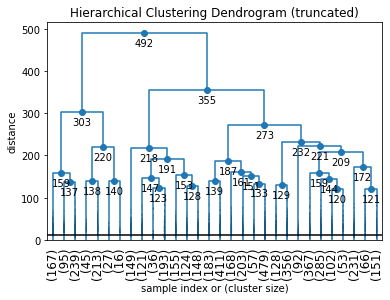

16 0.19968598819594002 0.27667782423672893


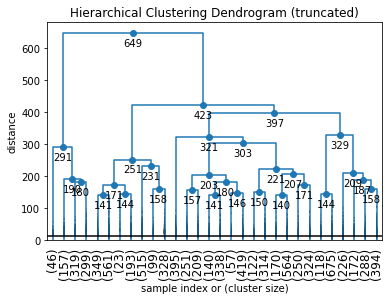

46 0.22193122255327374 0.28442692911814776
100 100


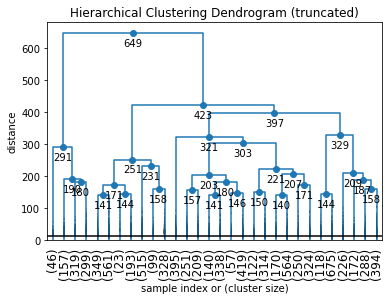

46 0.22193122255327374 0.28442692911814776


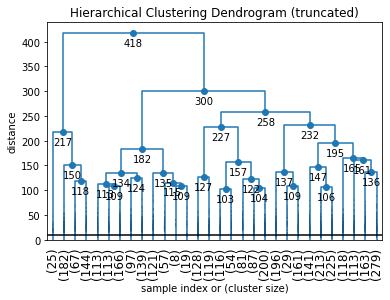

25 0.20343921829408512 0.26992183274607773
100 100


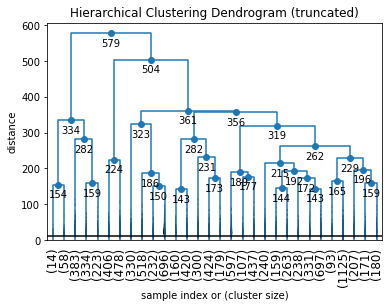

14 0.25385092107033663 0.289712850387484


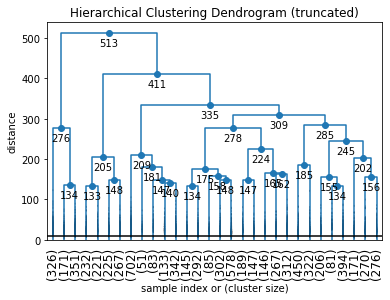

71 0.19638297483529735 0.2878387436592671
100 100


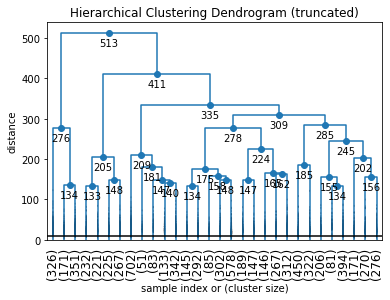

71 0.19638297483529735 0.2878387436592671


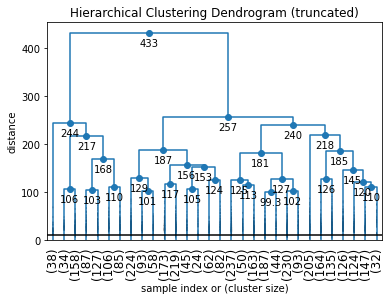

34 0.17757255550221876 0.2796058653214778
100 100


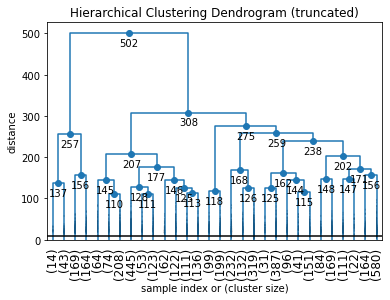

43 0.2794728732654987 0.32897337899743656


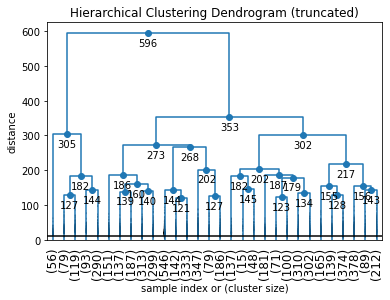

54 0.2667675996583053 0.38338520411512844
100 100


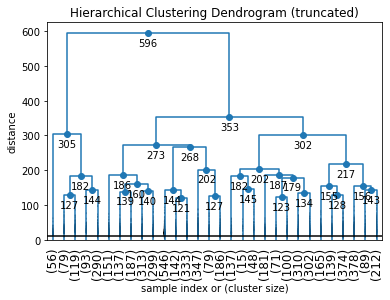

54 0.2667675996583053 0.38338520411512844


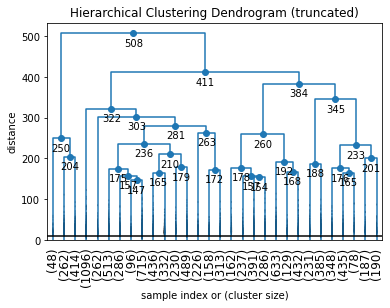

28 0.17912314290478065 0.22182820063137207
100 100

Collection: Development


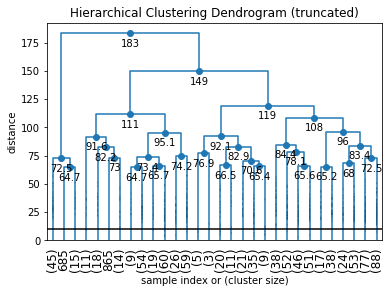

61 0.30893165991854254 0.30893165991854254


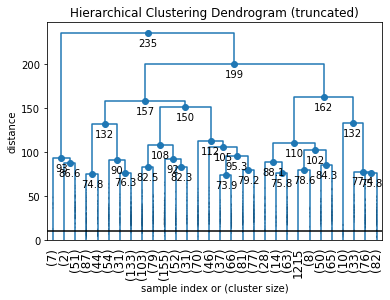

60 0.2087682127989553 0.33203848775992384
100 100


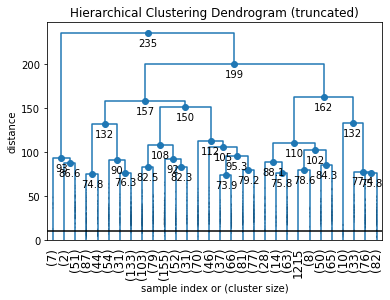

60 0.2087682127989553 0.33203848775992384


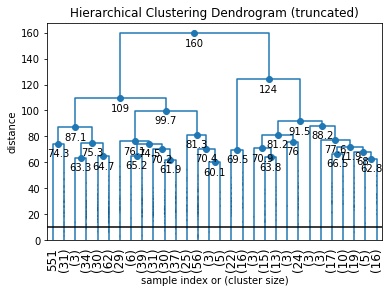

38 0.3358554504671213 0.3358554504671213
100 100


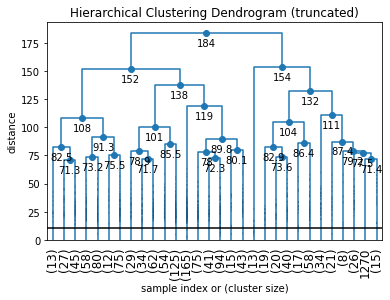

13 0.15246077123685664 0.2879363616038766


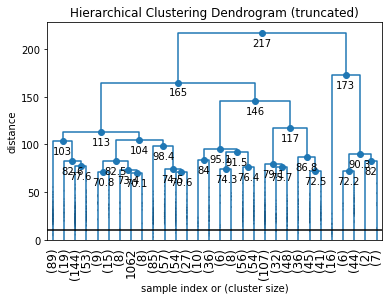

16 0.18036899863791292 0.3846078662400439
100 100


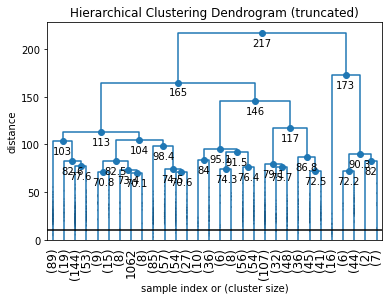

16 0.18036899863791292 0.3846078662400439


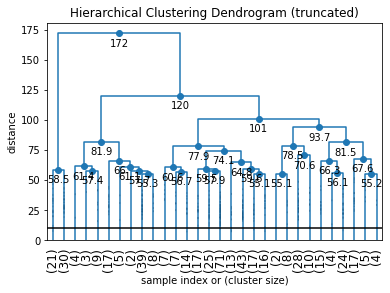

51 0.34433102387385356 0.38135709467052303
100 100


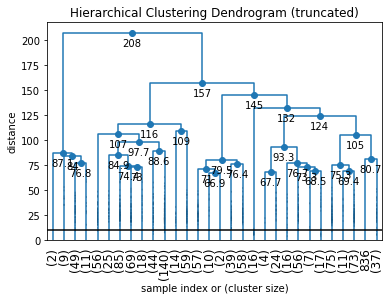

71 0.3564077282346145 0.3564077282346145


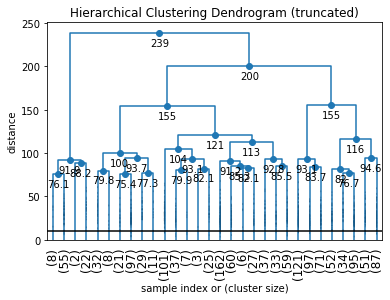

87 0.3809718112672131 0.3809718112672131
100 100


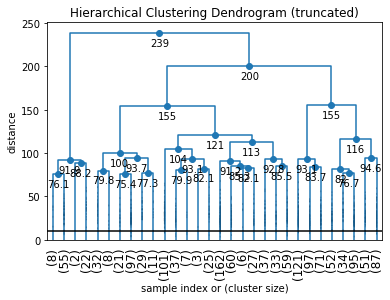

87 0.3809718112672131 0.3809718112672131


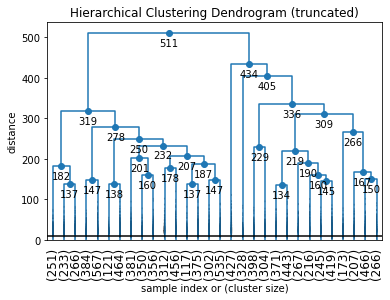

98 0.16519515295864912 0.165433938666562
100 100

Collection: Environment


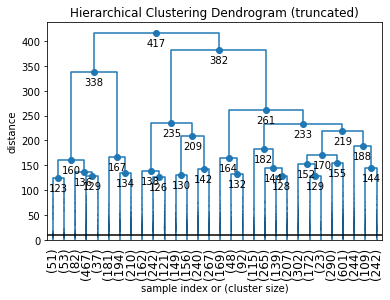

72 0.18511205578249046 0.20423172762039815


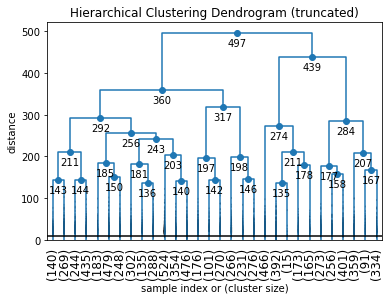

93 0.18074087225507626 0.1871498396017815
100 100


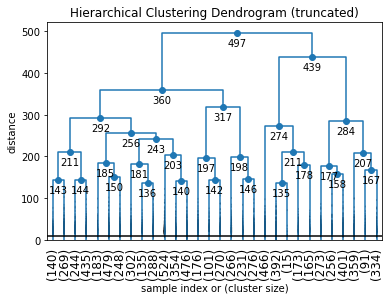

93 0.18074087225507626 0.1871498396017815


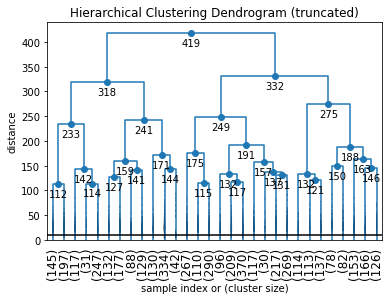

100 0.24147831967958114 0.24147831967958114
100 100


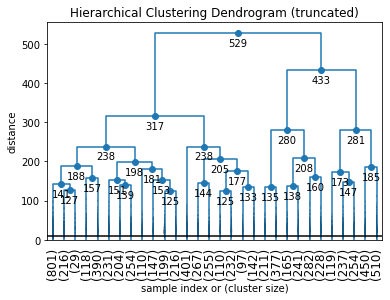

95 0.19865086737426996 0.20279570662054794


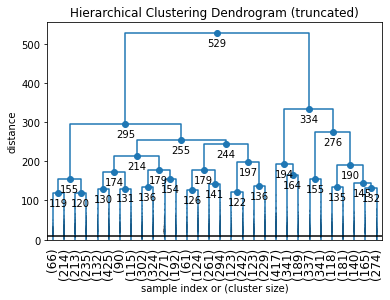

89 0.1583148666742336 0.15892265085777385
100 100


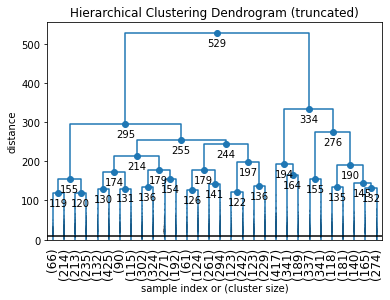

89 0.1583148666742336 0.15892265085777385


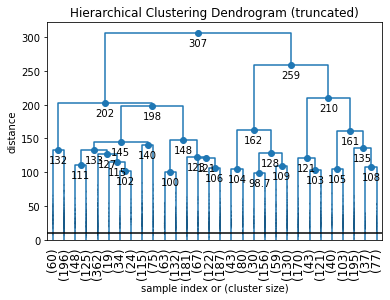

80 0.1956941891759372 0.1956941891759372
100 100


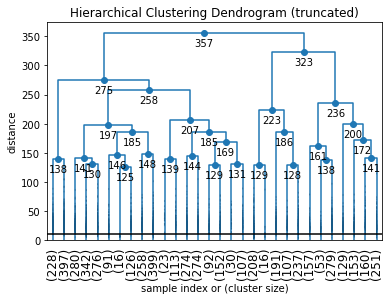

94 0.19313198294777603 0.19604822129215302


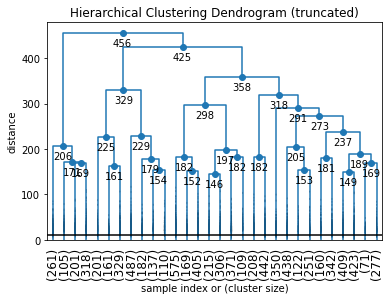

96 0.19220890342515934 0.19505581333566863
100 100


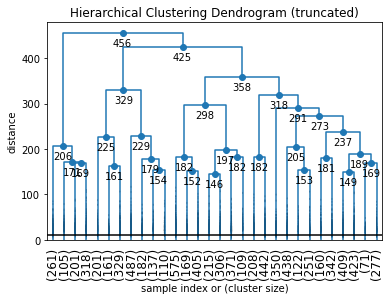

96 0.19220890342515934 0.19505581333566863


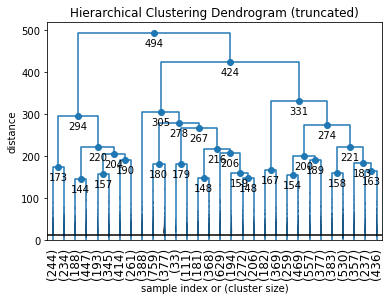

81 0.15450916908099935 0.15455538597875804
100 100

Collection: Industrialization


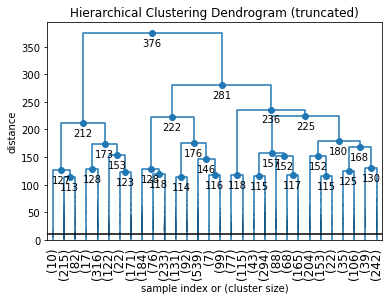

99 0.21615726180033054 0.21615726180033054


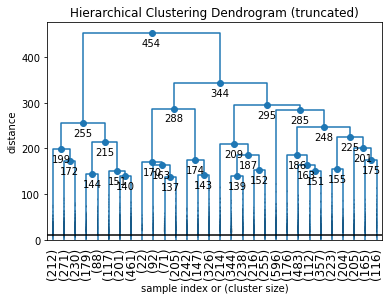

35 0.12949414417697205 0.1485272912040487
100 100


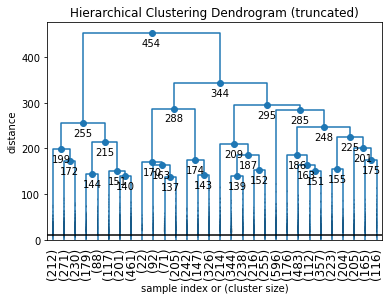

35 0.12949414417697205 0.1485272912040487


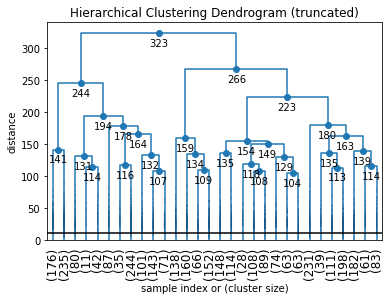

87 0.2060360275004965 0.20998646426828263
100 100


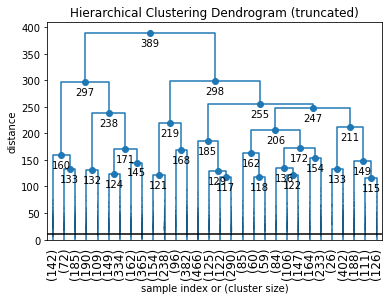

99 0.1623286652249503 0.16794382511833358


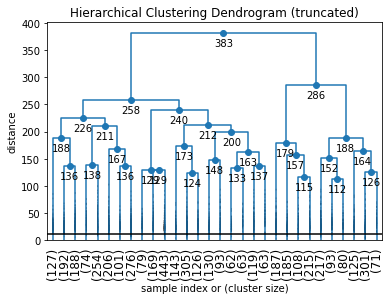

63 0.126699370423257 0.146293780246845
100 100


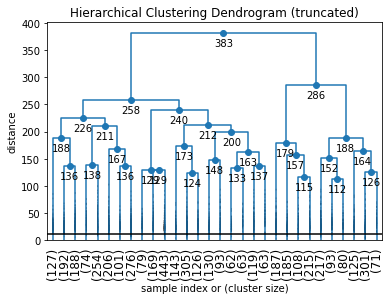

63 0.126699370423257 0.146293780246845


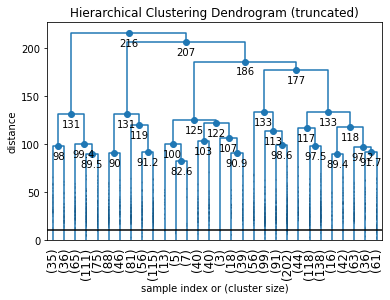

71 0.16958101631312708 0.17347745027739403
100 100


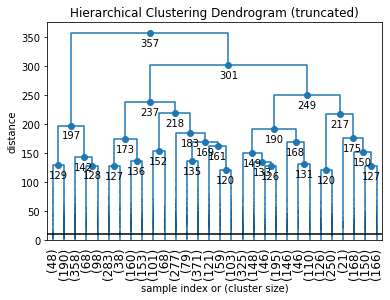

98 0.16959853479377554 0.17764295683278017


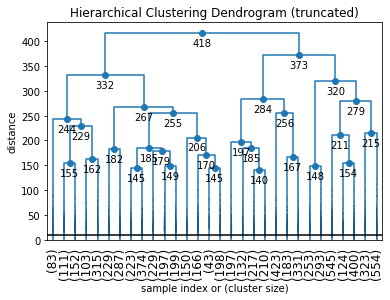

89 0.12658435550604713 0.1453155908594334
100 100


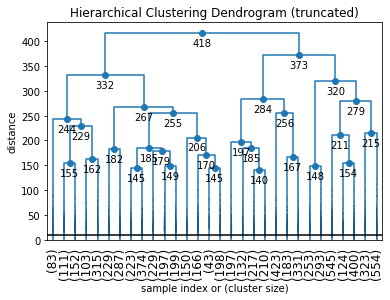

89 0.12658435550604713 0.1453155908594334


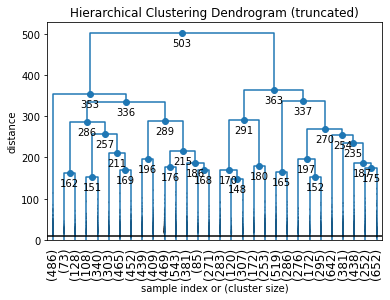

58 0.1167501324914264 0.1509632376554259
100 100

Collection: Lifestyle


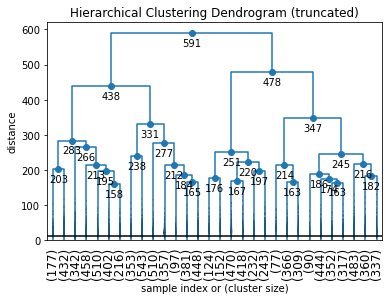

97 0.20933639927953382 0.21050075705254598


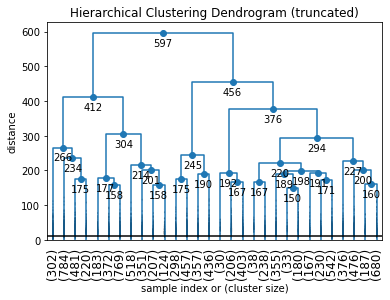

99 0.1461829361091089 0.1461829361091089
100 100


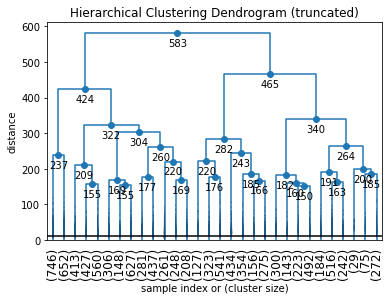

100 0.1911839612929694 0.1911839612929694


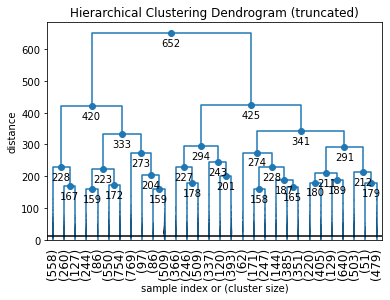

100 0.16971231463261702 0.16971231463261702
100 100


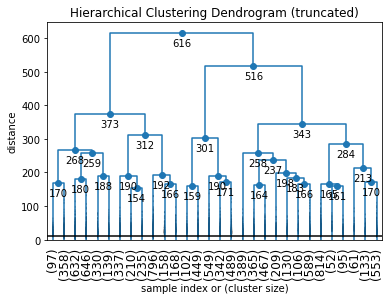

100 0.14839613070068766 0.14839613070068766


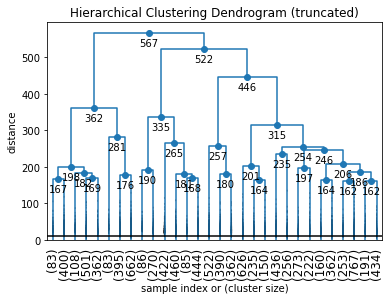

85 0.148402390999018 0.20864130884300616
100 100


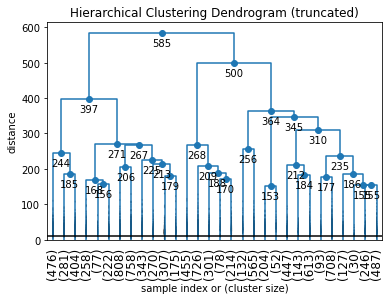

34 0.1632170377603321 0.1788174000768918


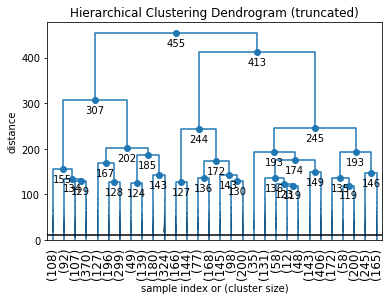

86 0.16686359388592725 0.18318550200601086
100 100


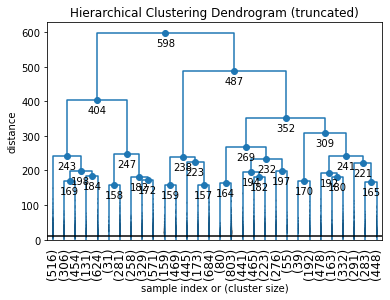

68 0.12663769585470322 0.1293464017605993


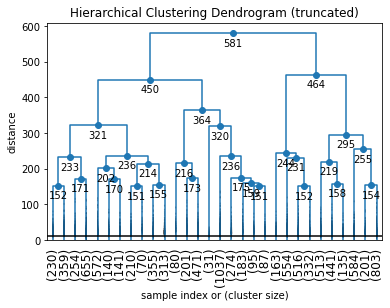

58 0.166387439264795 0.17509755565965718
100 100


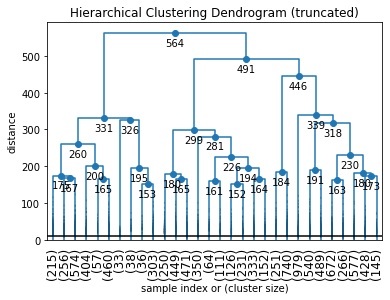

31 0.13679893621267666 0.1978137202220144


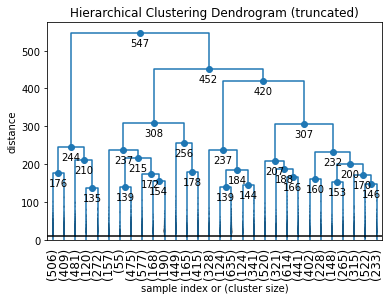

88 0.16422845481711298 0.19145353280536329
100 100


In [14]:
datasets = ['dataset_agriculture', 'dataset_development', 'dataset_environment', 'dataset_industrialization', 'dataset_lifestyle']
models = ['model_agriculture', 'model_development', 'model_environment', 'model_industrialization', 'model_lifestyle']
temp_dist= [set() for _ in range(9)]
for dataset, model in zip(datasets,models):

    # Printing the collection name.
    collection_name = dataset[8:]
    print('\nCollection:',collection_name.capitalize())

    # Loading the dataset and the model from the drive.
    file = open('Datasets/'+dataset, 'rb')
    dataset = pickle.loads(zlib.decompress(pickle.load(file)))
    file.close()
    model = Doc2Vec.load('Models/'+model)

    # Collecting the article_ids, and corresponding article_vectors for each class.
    temp_ids = [[] for _ in range(9)]
    temp_vectors = [[] for _ in range(9)]
    temp_datasets = [[] for _ in range(9)]
    temp_titles = [[] for _ in range(9)]
    
    for i in dataset:
        if i[6]=='Unemp' and i[-1]=='Slow':
            if i[0] not in temp_ids[0]:
                temp_dist[0].add(i[-5])
                temp_ids[0].append(i[0])
                temp_titles[0].append(i[1])
                temp_vectors[0].append(model.docvecs[i[0]])
                temp_datasets[0].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Unemp' and i[-1]=='Average':
            if i[0] not in temp_ids[1]:
                temp_dist[1].add(i[-5])
                temp_ids[1].append(i[0])
                temp_titles[1].append(i[1])
                temp_vectors[1].append(model.docvecs[i[0]])
                temp_datasets[1].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Unemp' and i[-1]=='Fast':
            if i[0] not in temp_ids[2]:
                temp_ids[2].append(i[0])
                temp_dist[2].add(i[-5])
                temp_titles[2].append(i[1])
                temp_vectors[2].append(model.docvecs[i[0]])
                temp_datasets[2].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Agri' and i[-1]=='Slow':
            if i[0] not in temp_ids[3]:
                temp_ids[3].append(i[0])
                temp_dist[3].add(i[-5])
                temp_titles[3].append(i[1])
                temp_vectors[3].append(model.docvecs[i[0]])
                temp_datasets[3].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Agri' and i[-1]=='Average':
            if i[0] not in temp_ids[4]:
                temp_dist[4].add(i[-5])
                temp_ids[4].append(i[0])
                temp_titles[4].append(i[1])
                temp_vectors[4].append(model.docvecs[i[0]])
                temp_datasets[4].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Agri' and i[-1]=='Fast':
            if i[0] not in temp_ids[5]:
                temp_ids[5].append(i[0])
                temp_dist[5].add(i[-5])
                temp_titles[5].append(i[1])
                temp_vectors[5].append(model.docvecs[i[0]])
                temp_datasets[5].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Non Agri' and i[-1]=='Slow':
            if i[0] not in temp_ids[6]:
                temp_dist[6].add(i[-5])
                temp_ids[6].append(i[0])
                temp_titles[6].append(i[1])
                temp_vectors[6].append(model.docvecs[i[0]])
                temp_datasets[6].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Non Agri' and i[-1]=='Average':
            if i[0] not in temp_ids[7]:
                temp_ids[7].append(i[0])
                temp_dist[7].add(i[-5])
                temp_titles[7].append(i[1])
                temp_vectors[7].append(model.docvecs[i[0]])
                temp_datasets[7].append([i[0],model.docvecs[i[0]]])
        if i[6]=='Non Agri' and i[-1]=='Fast':
            if i[0] not in temp_ids[8]:
                temp_ids[8].append(i[0])
                temp_dist[8].add(i[-5])
                temp_titles[8].append(i[1])
                temp_vectors[8].append(model.docvecs[i[0]])
                temp_datasets[8].append([i[0],model.docvecs[i[0]]])
    names = ['unemp_avg','unemp_slow','unemp_fast','agri_avg','agri_slow','agri_fast','non_agri_avg','non_agri_slow','non_agri_fast']
    df = pd.DataFrame()
    df_ids = pd.DataFrame()
    for i in [0,1,3,4,6,7]:
        art1,art2,indA1,indA2,indx1,indx2 = get_pat_res(temp_vectors[i],temp_vectors[i+1])
        titles1 = get_filtered(temp_titles[i],indx1,indA1,art1)
        titles2 = get_filtered(temp_titles[i+1],indx2,indA2,art2)
        ids1 = get_filtered(temp_ids[i],indx1,indA1,art1)
        ids2 = get_filtered(temp_ids[i+1],indx2,indA2,art2)
        print(len(ids1),len(ids2))
        rndm = sample([a for a in range(len(titles1))],10)
        df[names[i]+'_title'] = [titles1[a] for a in rndm]
        df[names[i]+'_id']=[ids1[a] for a in rndm]
        df_ids[names[i]+'_id'] = ids1[:100] + ['0' for _ in range(100-len(ids1))]
        rndm = sample([a for a in range(len(titles2))],10)
        df[names[i+1]+'_title'] = [titles2[a] for a in rndm]
        df[names[i+1]+'_id']=[ids2[a] for a in rndm]
        df_ids[names[i+1]+'_id'] = ids2[:100] + ['0' for _ in range(100-len(ids2))]
        
    df.to_excel('DocTag2Vec/'+collection_name+'.xlsx',index=False)
    df_ids.to_excel('DocTag2Vec/'+collection_name+'_ids.xlsx',index=False)
        